<a href="https://colab.research.google.com/github/sgagankumar/AgriCloud_IOT_PROJECT/blob/master/Behavioural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UDACITY SIMULATOR BEHAVIOURAL CLONING TECHNIQUE

In [0]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [0]:
!ls track

driving_log.csv  IMG


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
random.seed(0)
import os

In [0]:
datadir = 'track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth',-1)
# data.head()

In [0]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


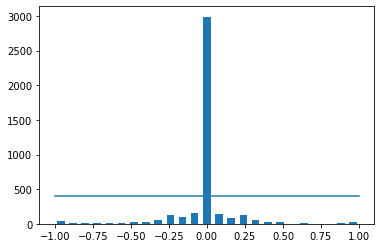

In [0]:
num_bins=25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) *0.5
# print(center)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total Data   :  4053
Removed Data :  2590
remaining: 1463


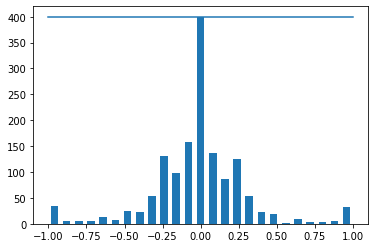

In [0]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('Total Data   : ', len(data))
print('Removed Data : ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:',len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples : {}\nValid Samples    : {}'.format(len(X_train), len(X_valid)))

Training Samples : 1170
Valid Samples    : 293


Text(0.5, 1.0, 'Validation set')

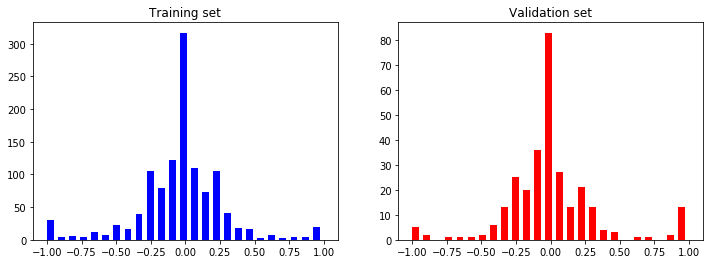

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

In [0]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x":(-0.1,0.1), "y":(-0.1,0.1)})
    image = pan.augment_image(image)
    return image

In [0]:
def img_rand_brightness(image):
    bright = iaa.Multiply((0.2, 1.2))
    image = bright.augment_image(image)
    return image

In [0]:
def img_rand_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1, 'Modified Image - Angle:-0.05')

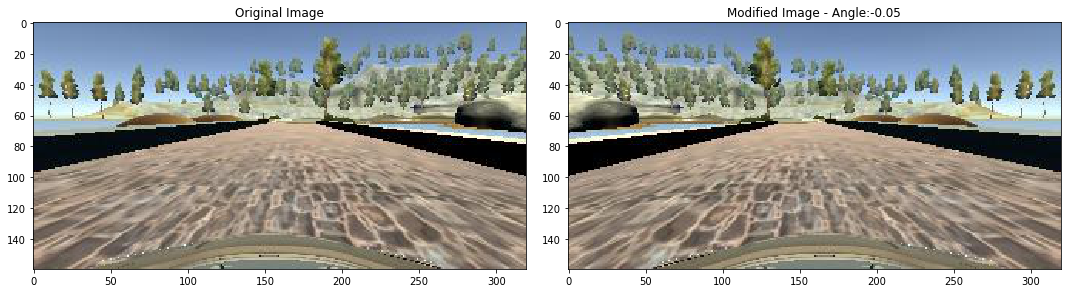

In [0]:
rand_index=random.randint(0, 1000)
image = image_paths[rand_index]
steering = steerings[rand_index]

original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
panned_image = pan(original_image)
bright_image = img_rand_brightness(original_image)
flip_image, steering = img_rand_flip(original_image, steering)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout() 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(flip_image)             # Values : zoomed_image, panned_image, bright_image, flip_image
axs[1].set_title('Modified Image - Angle:'+str(steering))

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_rand_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_rand_flip(image, steering_angle)
    return image, steering_angle

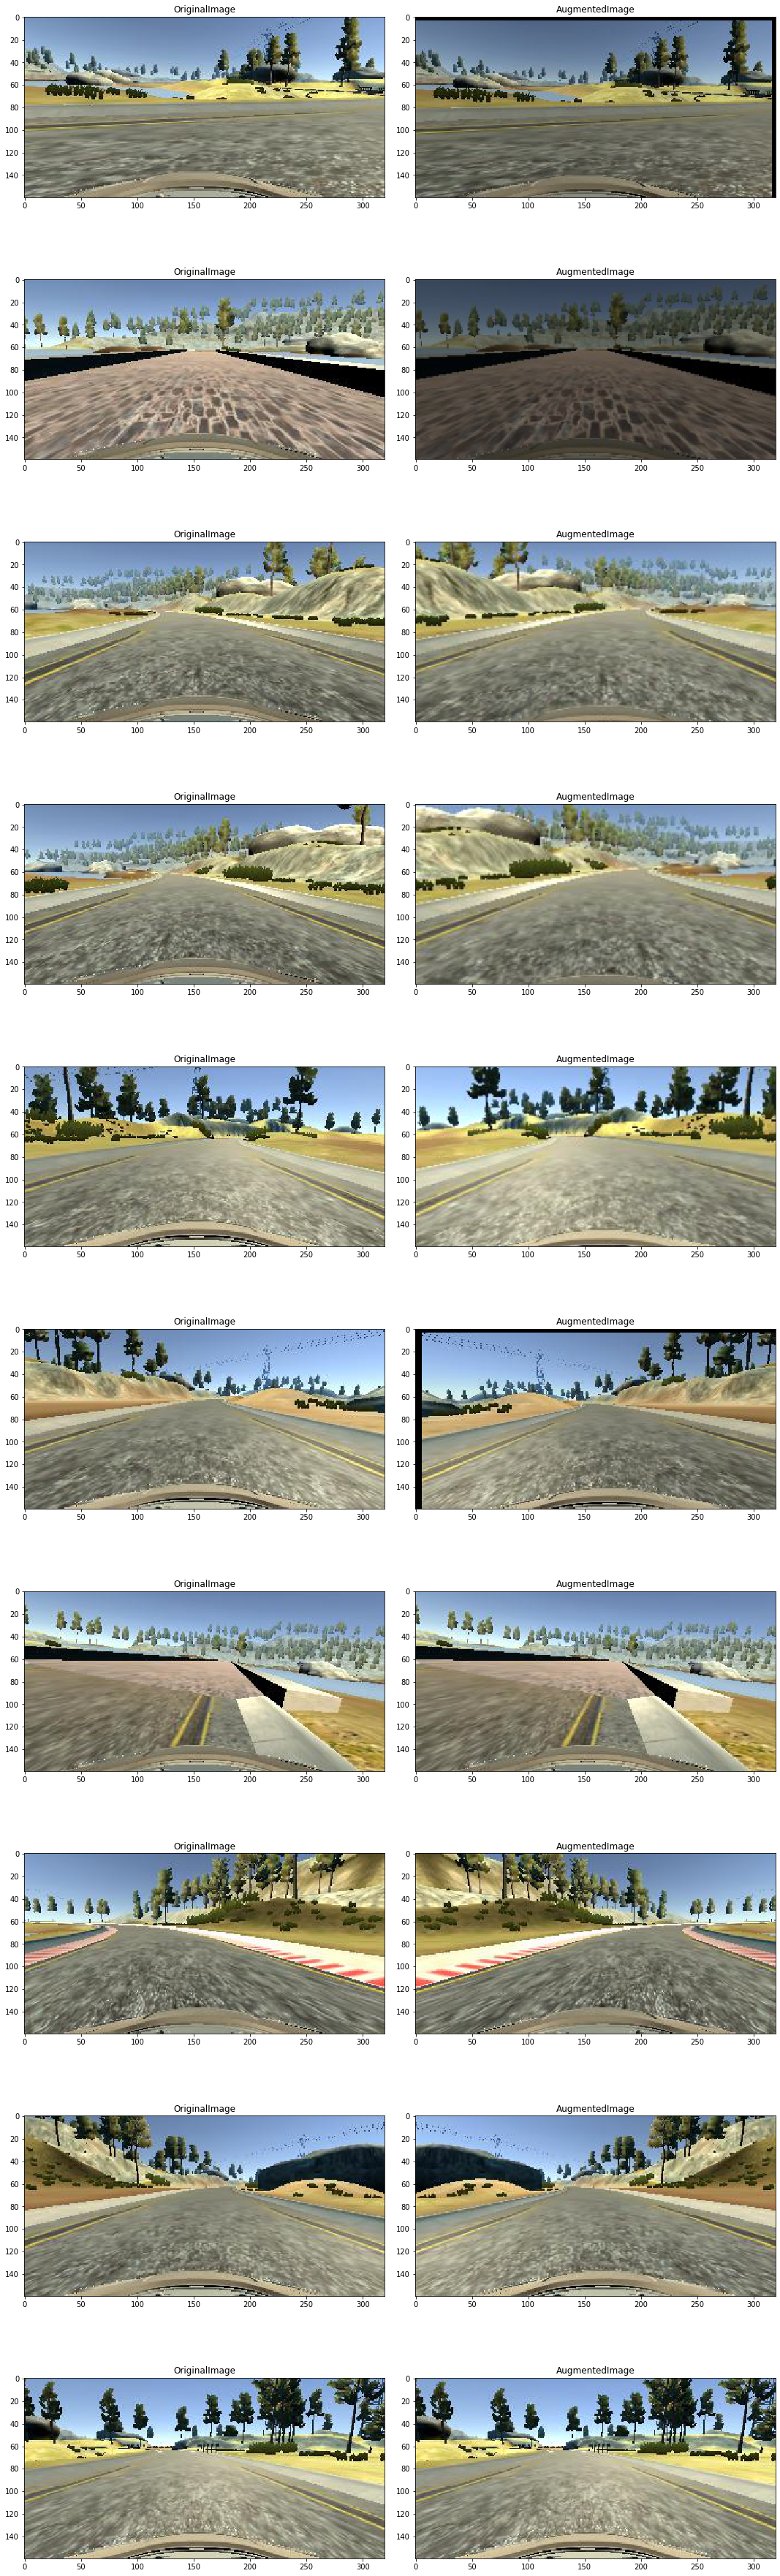

In [0]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
for i in range(10):
    randnum = random.randint(0, len(image_paths)-1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title('OriginalImage')
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('AugmentedImage')

In [0]:
def img_preprocess(img):
    # img = mpimg.imread(img)
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
# preprocessed_image = img_preprocess(image)

# fig, axs = plt.subplots(1, 2, figsize=(15, 10))
# fig.tight_layout()
# axs[0].imshow(original_image)
# axs[0].set_title('Original Image')
# axs[1].imshow(preprocessed_image)
# axs[1].set_title('Preprocessing Image')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img=[]
        batch_steering=[]

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            
            im=img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

In [0]:
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_valid = np.array(list(map(img_preprocess, X_valid)))

In [0]:
# plt.imshow(X_train[random.randint(0, len(X_train)-1)])
# print(X_train.shape)

In [0]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    # model.add(Dropout(0.5))
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu'))
    # model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='elu'))
    # model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='elu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    optimizerAdam = Adam(lr = 0.001)
    model.compile(loss='mse', optimizer=optimizerAdam)
    return model

In [0]:
model = nvidia_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [0]:
# history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), steps_per_epoch=300, epochs=10, validation_data = batch_generator(X_valid, y_valid, 100, 0), validation_steps=200, verbose=1, shuffle=1)

Epoch 1/10
300/300 [==============================] - 177s 589ms/step - loss: 0.1395 - val_loss: 0.0743
Epoch 2/10
300/300 [==============================] - 170s 566ms/step - loss: 0.0679 - val_loss: 0.0605
Epoch 3/10
300/300 [==============================] - 170s 566ms/step - loss: 0.0706 - val_loss: 0.0644
Epoch 4/10
300/300 [==============================] - 171s 570ms/step - loss: 0.0579 - val_loss: 0.0415
Epoch 5/10
300/300 [==============================] - 171s 571ms/step - loss: 0.0495 - val_loss: 0.0369
Epoch 6/10
300/300 [==============================] - 171s 568ms/step - loss: 0.0456 - val_loss: 0.0305
Epoch 7/10
300/300 [==============================] - 170s 568ms/step - loss: 0.0412 - val_loss: 0.0254
Epoch 8/10
300/300 [==============================] - 170s 568ms/step - loss: 0.0385 - val_loss: 0.0267
Epoch 9/10
300/300 [==============================] - 170s 568ms/step - loss: 0.0369 - val_loss: 0.0279
Epoch 10/10
300/300 [==============================] - 172s 572m

Text(0.5, 0, 'Epoch')

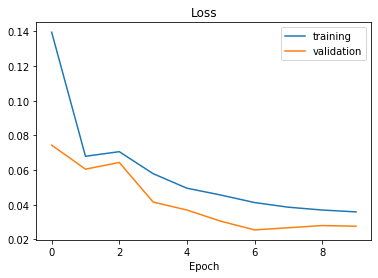

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')